# Выявление профилей потребления

Нам представлены данные с транзакциями интернет-магазина товаров для дома и быта «Пока все ещё тут».  
Нужно провести сегментацию покупателей, которая может помочь в разработке более персонализированных предложений для покупателей

**План работы**: 

    1. Общая информация о данных
    
    2. Предобработка данных:
    2.1. преобразование типов данных
    2.2. проверка на неявные дубли
    2.3. проверка и удаление выбросов при необходимости
    2.4. добавление новых столбцов: месяц заказа, стоимость (количество*цену) и категория товаров (сделаю 5: растения(рассада, семена), хозтовары, кухонная утварь, декор и прочие)
    
    3. Исследовательский анализ данных:  
    3.1. посмотрим как менялись заказы по кол-ву и сумме по месяцам  
    3.2. посмотрим на категории: какие приносят больше денег, какие чаще заказывают, есть ли сезонность каких-то категорий  
    3.3. посмотрим на покупателей: как часто заказывают, есть ли постоянные  
    
    4. Кластеризация покупателей:   
    4.1. подготовка данных: сводная таблица по клиентам - со средним количеством заказов, ср.кол-вом товара, ср.ценой и средней выручкой  
    4.2. нормализация данных (StandardScaler)   
    4.3. определяю оптимальное количество кластеров с помощью метода "локтя"   
    4.4. использую kmeans   
    4.5. визуализация кластеров, описание кластеров по ним  
    4.6. переношу получившиеся кластеры в нашу таблицу с данными   
    4.7. анализ и описание кластеров по покупкам, категориям товаров и их сезонности
    
    5. Проверить гипотезы:  
    5.1. Н0 - нет различий между кластерами по среднему чеку. Н1 - есть различия между кластерами по среднему чеку  
    5.2. Н0 - нет различий между кластерами по частоте покупок. Н1 - есть различия между кластерами по частоте покупок


    6. Выводы и рекомендации  
    

## ОБЩАЯ ИНФОРМАЦИЯ

In [16]:
#библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import kruskal

In [2]:
#данные
url_data =
data = pd.read_csv(url_data)

In [3]:
#функция для вывода информации о таблице и дублях
def analyze_dataframe(df):
    #выводим первые 5 строк датафрейма
    print('\033[1m' + 'head:' + '\033[0m')
    print(df.head())

    #выводим информацию о датафрейме
    print('\033[1m' + 'info:' + '\033[0m')
    print(df.info())

    #выводим форму датафрейма
    print('\033[1m' + 'shape:' + '\033[0m')
    print(df.shape)

    #вычисляем и выводим количество дублирующихся строк
    duplicate_count = df.duplicated().sum()
    print('\033[1m' + 'Количество дубликатов в таблице:' + '\033[0m')
    print(duplicate_count)

In [4]:
analyze_dataframe(data)

head:
         date                           customer_id  order_id  \
0  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  
0    Комнатное растение в горшке Алое Вера, d12, h30         1  142.0  
1  Комнатное растение в горшке Кофе Арабика, d12,...         1  194.0  
2                        Радермахера d-12 см h-20 см         1  112.0  
3                   Хризолидокарпус Лутесценс d-9 см         1  179.0  
4                     Циперус Зумула d-12 см h-25 см         1  112.0  
info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------      

Видим, что в даты неверный тип данных, в остальном - все ок. Явных дубликатов и пропусков нет.

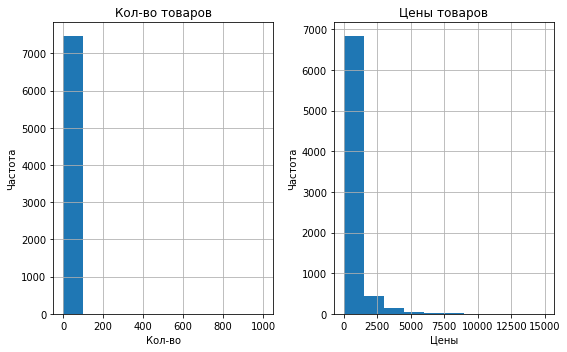

In [5]:
#создаем фигуру с двумя подграфиками
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

#построим первую гистограмму для 'quantity'
data.hist(column='quantity', ax=axs[0])
axs[0].set_title('Кол-во товаров')
axs[0].set_xlabel('Кол-во')
axs[0].set_ylabel('Частота')

#построим вторую гистограмму для 'price'
data.hist(column='price', ax=axs[1])
axs[1].set_title('Цены товаров')
axs[1].set_xlabel('Цены')
axs[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

Видим что есть выбросы.

### Промежуточный итог

В нашем распоряжении 7474 строк данных.
Этих данных достаточно для анализа.
Видим что имеются некорректные типы данных и выбросы. Пропуски и явные дубликаты отсутствуют.

## ПРЕДОБРАБОТКА ДАННЫХ


### Преобразование типов данных

In [6]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

In [7]:
#посмотрим за какой период представлены данные
display(data['date'].min())
data['date'].max()

Timestamp('2018-10-01 00:00:00')

Timestamp('2020-01-31 15:00:00')

Видим, что данные представлены с 1 октября 2018 по 31 января 2020 г

### Дубликаты

Проверим на неявные дубли - дубликаты без учета даты

In [8]:
data[data.duplicated(subset=['customer_id', 'order_id', 'product', 'quantity'], keep=False)]

,date,customer_id,order_id,product,quantity,price
15,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"Мини-сковорода Marmiton ""Сердце"" с антипригарн...",1,239.0
16,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,Сковорода алюминиевая с антипригарным покрытие...,1,824.0
17,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,Стеклянная крышка для сковороды ALPENKOK 26 см...,1,262.0
18,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"Сушилка для белья напольная Colombo Star 18, 3679",1,1049.0
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
...,...,...,...,...,...,...
6716,2019-10-30 07:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6717,2019-10-30 09:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0


Видим много дублей - одинаковые заказы в разные даты/время. Вероятнее всего это дублирование связано с тем, что данные представлены, например при выставлении счета и при выписывании накладной, или из разных программ учета.

Удалим дубли.

In [9]:
data = data[~data.duplicated(subset=['customer_id', 'order_id', 'product', 'quantity'], keep=False)]

Проверим дубликаты без учета даты и id покупателя.

In [10]:
data[data.duplicated(subset=['order_id', 'product', 'quantity'], keep=False)].sort_values(by='order_id')

,date,customer_id,order_id,product,quantity,price
512,2018-10-28 22:00:00,0b5ce2c7-acef-4a9a-b821-61a44ed05557,68785,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",1,374.0
538,2018-10-30 21:00:00,c1dd5c0e-51db-4a5d-91a3-5374cb20043d,68785,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",1,374.0
1154,2018-12-10 12:00:00,2f955596-4b13-432e-93f3-6433395aafe6,69283,Сушилка для белья на батарею НИКА СБ6-65 двухъ...,1,164.0
1160,2018-12-10 16:00:00,e3805ccd-2d64-4d0e-92dd-902293555c35,69283,Сушилка для белья на батарею НИКА СБ6-65 двухъ...,1,164.0
1196,2018-12-13 19:00:00,70d60304-4b3c-4f34-9430-1872ec6e6309,69345,Сушилка для белья Attribute ПРИМА 18 м синяя A...,1,974.0
1209,2018-12-15 07:00:00,22e4d79f-3613-4c22-8b01-7f880120bf5a,69345,Сушилка для белья Attribute ПРИМА 18 м синяя A...,1,974.0
1237,2018-12-17 14:00:00,4ea06f66-0876-4dec-8d14-ea994ffe435f,69410,Муляж Желудь 2 шт,3,22.0
1258,2018-12-18 20:00:00,caaa3f41-c9ab-4e3d-8b75-94e1d3a8d7b4,69410,Муляж Желудь 2 шт,3,22.0
1292,2018-12-21 11:00:00,266beb08-ec9b-43b4-89bb-ac60fa23ffee,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0
1384,2018-12-26 23:00:00,e0461045-4fcc-4731-8837-509f6534512a,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0


Видим, что есть номера заказов с разными id покупателя. Т.к товары в заказе полностью совпадает, означает что один и тот же покупатель имеет разные id  в разных программах учета. Оставим одну из строк каждого дубля, остальное удаляем.

In [11]:
data = data[~data.duplicated(subset=['order_id', 'product', 'quantity'], keep=False)]

In [12]:
#проверим
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5057 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5057 non-null   datetime64[ns]
 1   customer_id  5057 non-null   object        
 2   order_id     5057 non-null   int64         
 3   product      5057 non-null   object        
 4   quantity     5057 non-null   int64         
 5   price        5057 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 276.6+ KB


Избавились от дублей

### Новые столбцы

Создадим два столбца со стоимостью - количество * цену и месяцем заказа

In [13]:
data['cost'] = data['quantity']*data['price']

In [14]:
data['month'] = data['date'].dt.to_period('M')

Добавим столбец категории товаров. Выведем его из наименования c помощью словаря, созданного для каждой категории

In [15]:
#словарь категорий
categories = {
    'растения(рассада, семена)': ['рассада', 'растение', 'укроп', 'овсянница', 'гиностемма', 'змееголовник', 'эшшольция', 'лен',
                 'суккулент', 'герань', 'пуансеттия', 'алиссум', 'лавр', 'энотера', 'огурец', 'монарда', 'валериана',
                 'пеларгония', 'помидор', 'незабудка', 'вербейник', 'гортензия', 'бегония', 'георгин', 'анемона',
                 'роза', 'бакопа', 'гвоздика', 'флокс', 'петуния', 'котовник', 'вероника', 'лилейник', 'ясколк',
                 'декабрист', 'мята', 'фиалка', 'циперус', 'физостегия', 'калла', 'пиретрум', 'папоротник',
                 'калибрахоа', 'комнатн', 'бальзамин', 'эвкалипт', 'виола', 'клубни', 'ромашк', 'астра', 'любисток',
                 'капуста', 'базилик', 'петрушка', 'ампельн', 'цинния', 'седум', 'камнеломк', 'смолевка', 'шалфей',
                 'антуриум', 'фуксия', 'клен', 'лобелия', 'космея', 'тюльпан', 'кориандр', 'кодонанта', 'лаватера',
                 'хлорофитум', 'арбуз', 'томат', 'бархатцы', 'кипарисовик', 'цикламен', 'цинерария', 'солидаго',
                 'зверобой', 'тимьян', 'ранункулус', 'осина', 'салат', 'виноград', 'годеция', 'ель', 'рудбекия',
                 'дыня', 'колокольчик', 'вербена', 'кореопсис', 'календула', 'лапчатка', 'морков', 'гайлард',
                 'd-', 'настурция', 'гипсофила', 'хризантема', 'горох', 'земляника', 'дендробиум', 'аквилегия'],
    'хозтовары/быт.химия': ['тележка', 'сумка', 'сушилка', 'стремянк', 'совок', 'тряпка',
                  'гладильная доска', 'коврик', 'подголовник', 'губк', 'отжим',
                  'чехол', 'ёрш', 'ерш','крючок', 'дозатор', 'прищеп', 'основан',
                  'таз', 'штанга', 'шнур', 'термометр', 'мешок', 'держател',
                  'сушилка', 'щетка', 'тряпкодержатель', 'отделител', 'рассекат',
                  'корыто', 'сиденье', 'сетка', 'пробка', 'вантуз', 'ролик',
                  'рукав', 'салфетк', 'насадка', 'комплект', 'кольц', 'мыльниц',
                  'ведро', 'покрытие', 'веник', 'пакет', 'сито', 'сметк',
                  'швабра', 'перчат', 'бензин', 'урна', 'зажигал', 'средств', 'паста', 
                  'мыло', 'чистящ','ополаск', 'антижир', 'бальзам', 'концентр'],
    'кухонная утварь': ['ложка', 'вилка', 'нож', 'тарелка', 'кисточк', 'противен', 'варка',
                        'чайник', 'салатник', 'стакан', 'масленка', 'бидон', 'бак', 'венчик',
                        'круж', 'кувшин', 'ковш', 'рыбо', 'крышка', 'орехо', 'лопатк', 'посуд',
                        'фужер', 'овоще', 'форм', 'сахарниц', 'блюд', 'емкост', 'бульон',
                        'сковород', 'чай', 'миска', 'столов', 'толкушка', 'скреб', 'пресс',
                        'термос', 'терка', 'кастрюл', 'лоток', 'разделочн', 'картофел',
                        'хлеб', 'просеиватель', 'бокал'],
    'декор/ремонт/быт.техника': ['искусствен', 'карниз', 'рамка', 'ваза',
              'кашпо', 'ковер', 'ковёр', 'ковр', 'комод', 'этажерка', 'детский', 'стеллаж',
              'декор', 'муляж', 'светил', 'плед', 'скатерть', 'полотенц', 'подушк', 'одеял', 'наматра', 'ткань', 'кухонных',
              'простын', 'штора', 'махров', 'покрывал', 'жаккард', 'наволоч', 'вафель'
              'новогодн', 'корзин', 'контейнер', 'полк', 'вешал', 'плечик', 'банка', 'ящик', 'ключ', 'обувн',
              'кофр', 'подставка', 'короб', 'стяжк', 'фал', 'петля', 'линейк', 'шпингал', 'прецизион', 
              'штангенциркуль', 'скоба', 'сварка', 'пена', 'маска',
              'крепеж', 'сверел', 'сверл', 'фреза', 'шпагат', 'инструм', 'фиксат', 'ванна', 'решетк', 'алюмин',
              'весы', 'пылесос', 'окномойка', 'миксер', 'фен', 'утюг', 'кипятиль', 'соковыжималка']
}

#функция для категоризации
def categorize_product(product_name):
    for category, keywords in categories.items():
        if any(keyword in product_name.lower() for keyword in keywords):
            return category
    return 'неопределено' #для тех товаров, что не "нашлись"

In [16]:
data['category'] = data['product'].apply(categorize_product)

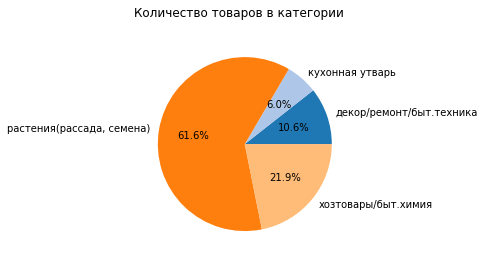

In [17]:
#проверим
data.pivot_table(
    index='category',
    values='product',
    aggfunc='count'
).plot(
    kind='pie',
    ylabel='',
    autopct='%1.1f%%',
    subplots=True,
    title='Количество товаров в категории',
    colors=plt.cm.tab20.colors
)
plt.legend().set_visible(False)
plt.show()

Категории созданы. Видим, что самое большое разнообразие товаров в категории Растения (61% всех товаров), Хозтовары/быт.химия составляет 22%. Меньше всего товаров Декор/ремонт/быт.техника и Кухонная утварь

### Выбросы

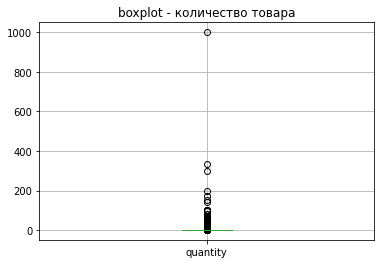

In [18]:
data.boxplot('quantity')

#настройка заголовков и меток
plt.title('boxplot - количество товара')
plt.suptitle('')  
plt.show()

Видим выброс в районе 1 тыс штук, посмотрим на строки с заказами выше 100 шт одного товара

In [19]:
data.query('quantity>100')

,date,customer_id,order_id,product,quantity,price,cost,month,category
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,8670.0,2018-11,декор/ремонт/быт.техника
586,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0,8260.0,2018-11,декор/ремонт/быт.техника
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,5800.0,2018-12,декор/ремонт/быт.техника
2431,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,20.0,3000.0,2019-03,декор/ремонт/быт.техника
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,15300.0,2019-05,декор/ремонт/быт.техника
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,49432.0,2019-06,декор/ремонт/быт.техника
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0,2019-06,хозтовары/быт.химия


Видим, что 1000 вантузов это выброс. Остальные заказы выглядят как оптовые закупки - для магазинов, яблоки для декораций, фотосъемок и т.д. Удалим заказ с вантузами, остальное - оставляем.

In [20]:
data = data.drop(index=5456, errors='ignore')

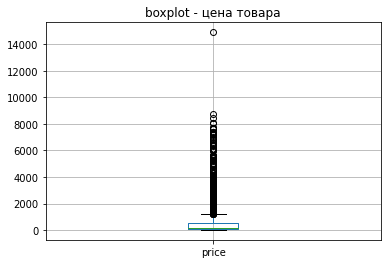

In [21]:
data.boxplot('price')

#настройка заголовков и меток
plt.title('boxplot - цена товара')
plt.suptitle('')  
plt.show()

Посмотрим на строчку с высокой ценой

In [22]:
data.query('price>14000')

,date,customer_id,order_id,product,quantity,price,cost,month,category
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400...,1,14917.0,14917.0,2019-07,"растения(рассада, семена)"


Удалять ее не будем - стоимость невысокая

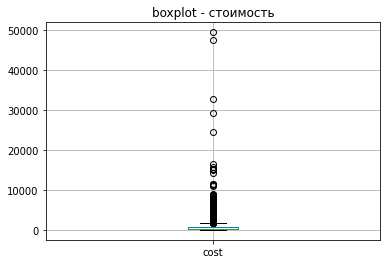

In [23]:
data.boxplot('cost')

#настройка заголовков и меток
plt.title('boxplot - стоимость')
plt.suptitle('')  
plt.show()

Видим единичные выбросы свыше 25 тыс стоимости. Посмотрим на эти строки

In [24]:
data.query('cost>20000')

,date,customer_id,order_id,product,quantity,price,cost,month,category
661,2018-11-06 12:00:00,1b2764ad-9151-4051-a46a-9b01b62e6335,68878,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см...",5,4874.0,24370.0,2018-11,хозтовары/быт.химия
1023,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Набор ножей Attribute CHEF 5 предметов AKF522,64,457.0,29248.0,2018-11,кухонная утварь
1299,2018-12-21 16:00:00,6987e6d6-a63a-4ce2-a2d0-f424092d235e,69504,Тележка багажная DELTA ТБР-22 синий грузоподъе...,57,574.0,32718.0,2018-12,хозтовары/быт.химия
1518,2019-01-15 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,Простынь вафельная 200х180 см WELLNESS RW180-0...,27,1755.0,47385.0,2019-01,"растения(рассада, семена)"
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,49432.0,2019-06,декор/ремонт/быт.техника


Видим, что это это тоже оптовые закупки, для магазинов, кафе и т.д. Оставляем. 

In [25]:
#проверим
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5056 entries, 0 to 7473
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5056 non-null   datetime64[ns]
 1   customer_id  5056 non-null   object        
 2   order_id     5056 non-null   int64         
 3   product      5056 non-null   object        
 4   quantity     5056 non-null   int64         
 5   price        5056 non-null   float64       
 6   cost         5056 non-null   float64       
 7   month        5056 non-null   period[M]     
 8   category     5056 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3), period[M](1)
memory usage: 395.0+ KB


Видим, что после удаления количества данных достаточно для анализа.

### Промежуточный итог

Проведена предобработка:
1. обработаны выбросы и дубли
2. изменены типы данных:
 - date - дата
3. созданы новые столбцы
 - month - с месяцем заказа month
 - category - категории товаров 
 - cost - стоимость заказа

## ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

### Заказы

Посмотрим на количество заказов по месяцам

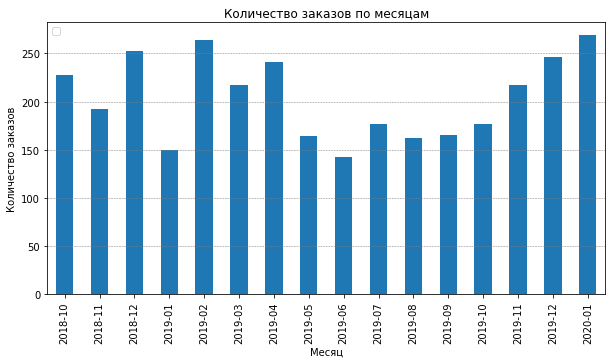

In [26]:
data.groupby('month')[['order_id']].nunique().plot(
    kind='bar',
    xlabel='Месяц',
    ylabel='Количество заказов',
    title='Количество заказов по месяцам',
    figsize=(10,5)
)
plt.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)
plt.legend('')
plt.show()

Видим, что каждый месяц имеем более 145 заказов, более 250 заказов было в декабре 2018, феврале 2019 и январе 2020. Самое небольшое количество заказов было в январе и июне 2019. Посмотрим сколько при этом было заказано товарный позиций.

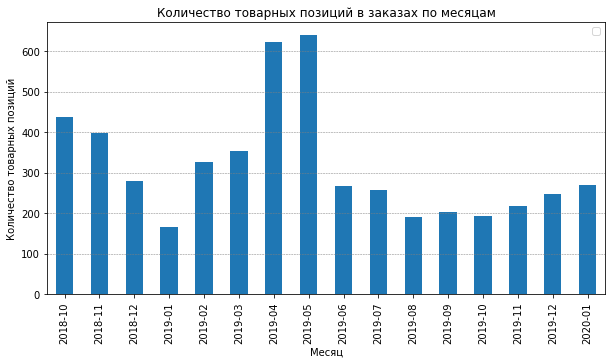

In [27]:
data.groupby('month')[['order_id']].count().plot(
    kind='bar',
    xlabel='Месяц',
    ylabel='Количество товарных позиций',
    title='Количество товарных позиций в заказах по месяцам',
    figsize=(10,5)
)
plt.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)
plt.legend('')
plt.show()

Видим, что кроме января 2019, каждый месяц заказывают более 190 различных товарных позиций. Пик разнообразия товаров приходится на апрель-май 2019. В 4 квартале 2018 года было больше всего заказанных разных позиций (290-430), чем в остальных месяцах 2019 (кроме апреля-мая). В январе существенно меньше разнообразия, чем в остальные месяцы. Посмотрим на выручку

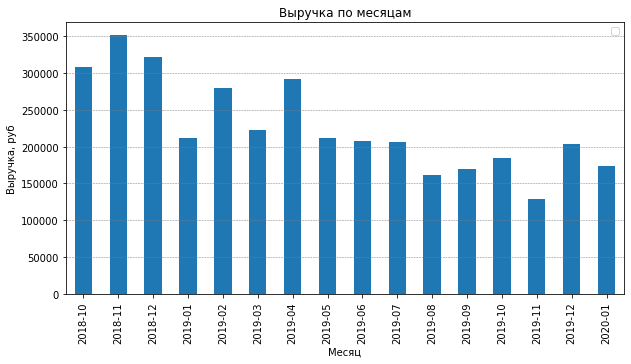

In [28]:
data.groupby('month')[['cost']].sum().plot(
    kind='bar',
    xlabel='Месяц',
    ylabel='Выручка, руб',
    title='Выручка по месяцам',
    figsize=(10,5)
)
plt.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)
plt.legend('')
plt.show()

Видим, что выручка составляет от 130 тыс до 310 тыс в месяц. Самыми удачными месяцами в плане выручки являются 4 квартал 2018 года, февраль и апрель 2019 г. Месяцами с наименьшей выручкой являются январь, июнь и ноябрь 2019 года. 

### Категории товаров

Посмотрим на продажи по категориям:

1. в целом количество заказов и выручка

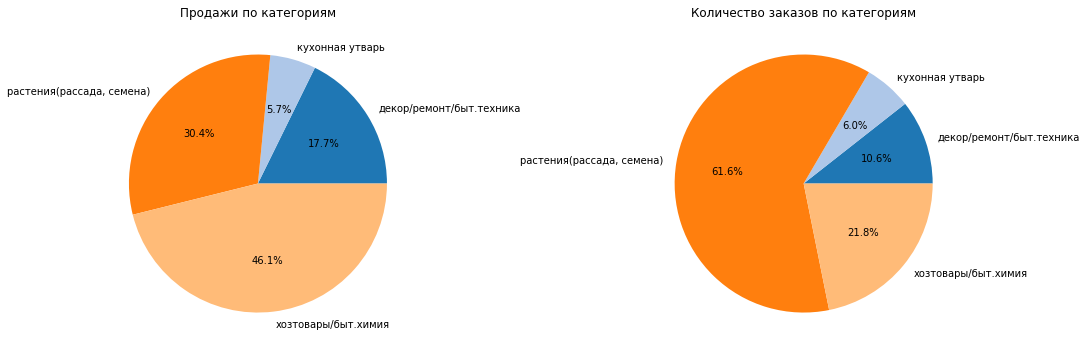

In [29]:
#создаем фигуру с двумя подграфиками
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

#График 1: Продажи по категориям
data.pivot_table(
    index='category',
    values='cost',
    aggfunc='sum'
).plot(
    kind='pie',
    ax=axs[0],
    ylabel='',
    autopct='%1.1f%%',
    subplots=True,
    colors=plt.cm.tab20.colors
)

axs[0].grid()
axs[0].set_title('Продажи по категориям')
axs[0].legend().set_visible(False)

#График 2: Количество заказов по категориям
data.pivot_table(
    index='category',
    values='order_id',
    aggfunc='count'
).plot(
    kind='pie',
    ax=axs[1],
    ylabel='',
    autopct='%1.1f%%',
    subplots=True,
    colors=plt.cm.tab20.colors
)

axs[1].grid()
axs[1].set_title('Количество заказов по категориям')
axs[1].legend().set_visible(False)

#отображаем графики
plt.tight_layout()
plt.show()


Видим, что в основной продажи и по сумме, и по количеству заказов относятся к двум категориям: растения(рассада, семена) и хозтовары. Более 60% заказов занимает категория растения, но при этом приносит только 30% всей выручки. Больше всего выручки 47% приносит категория хозтовары.

2. По месяцам по количеству заказов и продажам

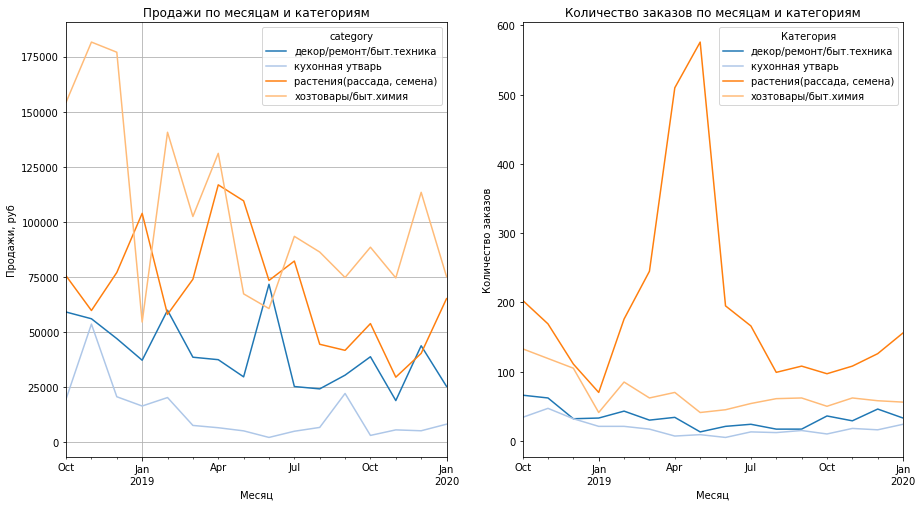

In [30]:
#создаем фигуру с двумя подграфиками
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

#График 1
data.pivot_table(
    index='month',
    columns='category',
    values='cost',
    aggfunc='sum'
).plot(
    kind='line',
    xlabel='Месяц',
    ylabel='Продажи, руб',
    title='Продажи по месяцам и категориям',
    ax=axs[0],
    color=plt.cm.tab20.colors
)
axs[0].grid()
axs[0].set_title('Продажи по месяцам и категориям')

#График 2
data.pivot_table(
    index='month',
    columns='category',
    values='order_id',
    aggfunc='count'
).plot(
    kind='line',
    xlabel='Месяц',
    ylabel='Количество заказов',
    title='Количество заказов по месяцам и категориям',
    ax=axs[1],
    color=plt.cm.tab20.colors
)

axs[1].grid()
axs[1].set_title('Количество заказов по месяцам и категориям')
axs[1].legend().set_visible(False)

plt.legend(title='Категория')
plt.grid()
plt.show()

Видим, что растения чаще заказывают, особенно заметен пик заказов весной, время посадок (апрель-май). Выручка в мае-июне по категории растения даже выше выручки категории за хозтовары. Также видим что в январе продажи сильно проваливаются (и по количеству заказов, и по выручке), что можно объяснить новогодними выходными.

### Пользователи

Посмотрим сколько всего уникальных клиентов

In [31]:
data['customer_id'].nunique()

2204

Посмотрим как они распределены по месяцам

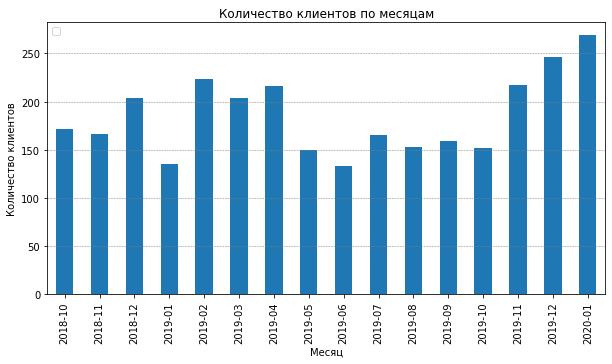

In [32]:
data.groupby('month')[['customer_id']].nunique().plot(
    kind='bar',
    xlabel='Месяц',
    ylabel='Количество клиентов',
    title='Количество клиентов по месяцам',
    figsize=(10,5)
)
plt.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)
plt.legend('')
plt.show()

Видим, что каждый месяц более 140 уникальных клиентов. Более 200 новых клиентов появилось в декабре 2018, феврале, марте, апреле, ноябре, декабре 2019 и январе 2020.Самое маленькое количество новых клиентов было в январе и июне 2019 года.

Посмотрим как часто пользователи заказывают 

In [33]:
customer_orders = data.groupby('customer_id')['order_id'].nunique().reset_index()

#переименовываем столбец для удобства
customer_orders.columns = ['customer_id', 'count_orders']

#считаем количество клиентов для каждого количества заказов
customer_orders['count_orders'].value_counts().sort_index()

1      1345
2       833
3        18
4         4
7         1
16        1
34        1
125       1
Name: count_orders, dtype: int64

Клиенты, имеющие более 7 заказов, очень выделаются. Это выброс. Удалим их.

In [34]:
#посмотрим id клиента
customer_orders.query('count_orders>6')

,customer_id,count_orders
659,4d93d3f6-8b24-403b-a74b-f5173e40d7db,34
981,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,16
1572,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
1723,c971fb21-d54c-4134-938f-16b62ee86d3b,125


In [35]:
# Список идентификаторов клиентов, которых нужно удалить
customer_ids_to_remove = [
    "c971fb21-d54c-4134-938f-16b62ee86d3b", 
    "4d93d3f6-8b24-403b-a74b-f5173e40d7db",
    "73d1cd35-5e5f-4629-8cf2-3fda829d4e58",
    "b7b865ab-0735-407f-8d0c-31f74d2806cc"
]

# Удаляем строки с указанными идентификаторами клиентов
data = data[~data['customer_id'].isin(customer_ids_to_remove)]

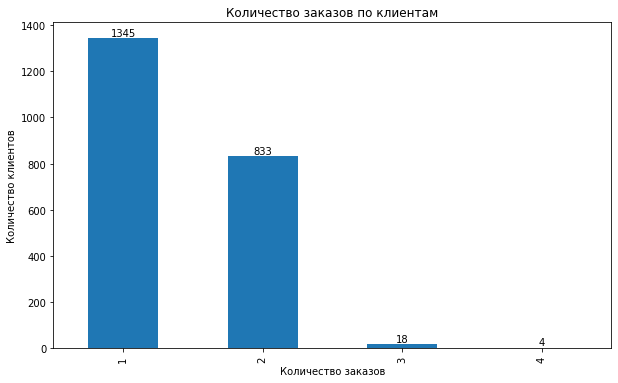

In [36]:
customer_orders = data.groupby('customer_id')['order_id'].nunique().reset_index()

#переименовываем столбец для удобства
customer_orders.columns = ['customer_id', 'count_orders']

#считаем количество клиентов для каждого количества заказов
order_counts = customer_orders['count_orders'].value_counts().sort_index()

#график
ax = order_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Количество заказов по клиентам')
plt.xlabel('Количество заказов')
plt.ylabel('Количество клиентов')

#добавляем количество клиентов на график
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.show()

Видим, что наши клиенты чаще всего не делают больше 2 заказов. 

Посмотрим как клиенты с разным количеством заказов распределены по периоду.

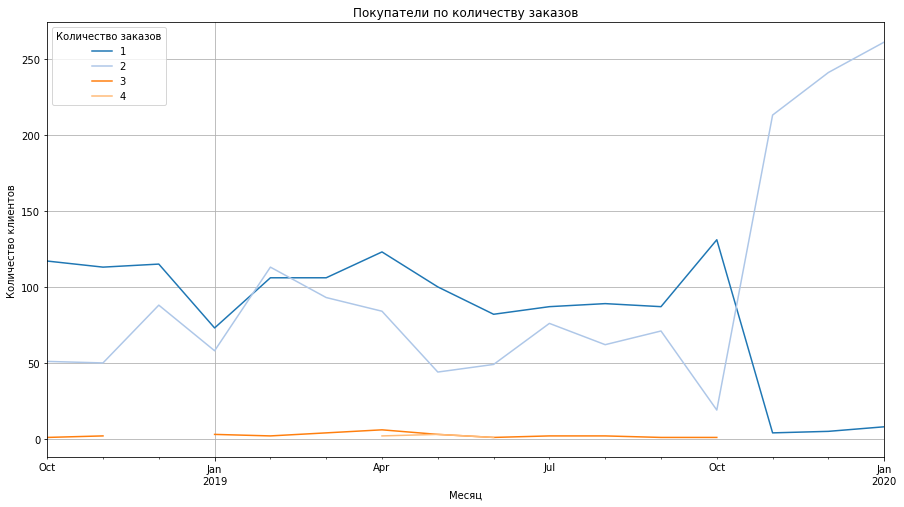

In [37]:
customer_orders = data.groupby('customer_id')['order_id'].nunique().reset_index()
customer_orders.columns = ['customer_id', 'count_orders']

#получаем месяцы, в которые клиенты сделали заказы
#добавляем столбец 'month' к customer_orders
month_orders = data.groupby(['customer_id', 'month'])['order_id'].nunique().reset_index()
month_orders.columns = ['customer_id', 'month', 'order_count']

#объединяем данные
customer_orders = customer_orders.merge(month_orders, on='customer_id', how='left')

customer_orders.pivot_table(
    index='month',
    columns='count_orders',
    values='customer_id',
    aggfunc='count'
).plot(
    kind='line',
    figsize=(15, 8),
    xlabel='Месяц',
    ylabel='Количество клиентов',
    title='Покупатели по количеству заказов',
    color=plt.cm.tab20.colors
)

plt.legend(title='Количество заказов')
plt.grid()
plt.show()

Видим, что на протяжении всего периода до октября 2019 преобладали покупатели с 1 заказом. Клиенты свои 3 и 4 заказа набирали также в течение  всего периода до октября 2019.

В октябре 2019 произошло несколько изменений: 
 - увеличилось количество вторых заказов
 - клиенты, заказывающие более 2 заказов, отсутствуют

### Промежуточный вывод

Каждый месяц имеем более 145 заказов, более 250 заказов было в декабре 2018, феврале 2019 и январе 2020. Самое небольшое количество заказов было в январе и июне 2019.  
Кроме января 2019, каждый месяц заказывают более 190 различных товарных позиций. Пик разнообразия товаров приходится на апрель-май 2019. В 4 квартале 2018 года было больше всего заказанных разных позиций (290-430), чем в остальных месяцах 2019 (кроме апреля-мая). В январе существенно меньше разнообразия, чем в остальные месяцы.

Выручка составляет от 130 тыс до 310 тыс в месяц. Самыми удачными месяцами в плане выручки являются 4 квартал 2018 года, февраль и апрель 2019 г. Месяцами с наименьшей выручкой являются январь, июнь и ноябрь 2019 года. 

В основном продажи и по сумме, и по количеству заказов относятся к двум категориям: растения(рассада, семена) и хозтовары. Более 60% заказов занимает категория растения, но при этом приносит только 30% всей выручки. Больше всего выручки 47% приносит категория хозтовары.

Растения чаще заказывают, особенно заметен пик заказов весной, время посадок (апрель-май). Выручка в мае-июне по категории растения даже выше выручки категории за хозтовары. В январе продажи сильно проваливаются (и по количеству заказов, и по выручке), что можно объяснить новогодними выходными.

Каждый месяц более 140 уникальных клиентов. Более 200 новых клиентов появилось в декабре 2018, феврале, марте, апреле, ноябре, декабре 2019 и январе 2020.Самое маленькое количество новых клиентов было в январе и июне 2019 года.

Клиенты чаще всего не делают больше 2 заказов. Единицы заказывают более 4 заказов.

На протяжении всего периода до октября 2019 преобладали покупатели с 1 заказом. Клиенты свои 3 и 4 заказа набирали также в течение  всего периода до октября 2019.

В октябре 2019 произошло несколько изменений: 
 - увеличилось количество вторых заказов
 - клиенты, заказывающие более 2 заказов, отсутствуют

## Кластеризация

### Деление на кластеры

Распределим клиентов по сегментам (кластерам)

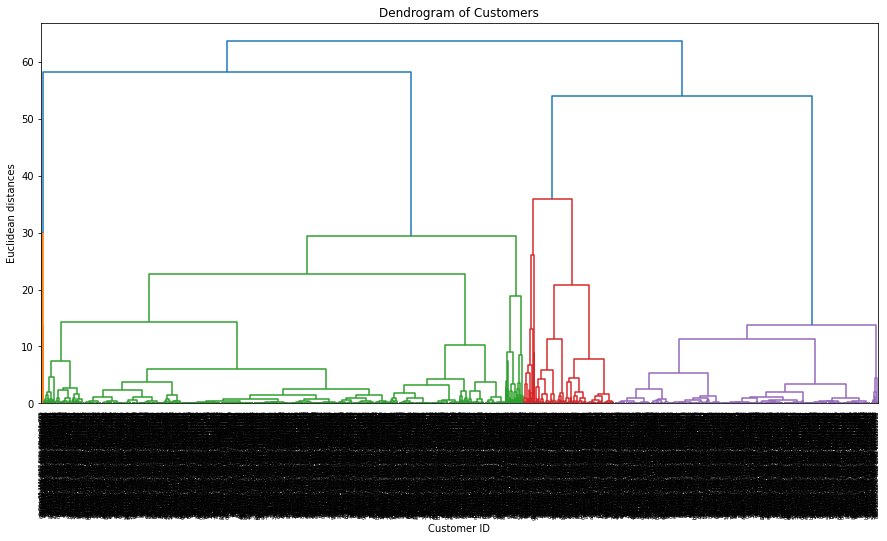

In [38]:
#агрегируем данные по customer_id
aggregated_data = data.groupby('customer_id').agg({
    'quantity': 'mean',
    'price': 'mean',
    'cost': 'mean',
    'order_id': 'nunique'
}).reset_index()

#переименуем столбцы для удобства
aggregated_data.columns = ['customer_id', 'total_quantity', 'average_price', 'average_cost', 'order_count']

#нормализуем данные
scaler = StandardScaler()
scaled_data = scaler.fit_transform(aggregated_data[['total_quantity', 'average_price', 'average_cost', 'order_count']])

#кластеризация
linked = linkage(scaled_data, method='ward')

#визуализация дендограммы
plt.figure(figsize=(15, 7))
dendrogram(linked, 
           orientation='top',
           labels=aggregated_data['customer_id'].values,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram of Customers')
plt.xlabel('Customer ID')
plt.ylabel('Euclidean distances')
plt.show()

Видим, что можно поделить клиентов на 4 кластера

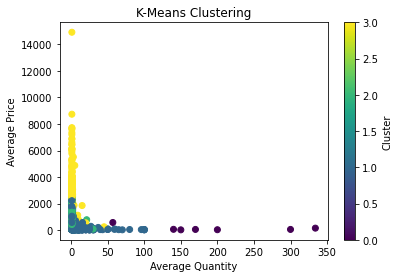

In [39]:
# Используем KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_data)

# Добавляем метки кластеров
aggregated_data['cluster'] = kmeans.labels_

# Визуализируем кластеры
plt.scatter(aggregated_data['total_quantity'], aggregated_data['average_price'], c=aggregated_data['cluster'])
plt.xlabel('Average Quantity')
plt.ylabel('Average Price')
plt.title('K-Means Clustering')
plt.colorbar(label='Cluster')
plt.show()

Посмотрим количество клиентов в каждом кластере

In [40]:
aggregated_data['cluster'].value_counts()

1    1251
2     805
3     137
0       7
Name: cluster, dtype: int64

Видим, что кластере 1 - самое большое кол-во клиентов - 1251 клиента, в 2 кластере - 805, в 3 кластере - 137, в 0 кластере - меньше всего, 7 клиентов.

Перенесем кластеры в таблицу с нашими данными

In [41]:
data = data.merge(aggregated_data[['customer_id', 'cluster']], on='customer_id', how='left')

In [42]:
#проверим
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4837 entries, 0 to 4836
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4837 non-null   datetime64[ns]
 1   customer_id  4837 non-null   object        
 2   order_id     4837 non-null   int64         
 3   product      4837 non-null   object        
 4   quantity     4837 non-null   int64         
 5   price        4837 non-null   float64       
 6   cost         4837 non-null   float64       
 7   month        4837 non-null   period[M]     
 8   category     4837 non-null   object        
 9   cluster      4837 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(3), period[M](1)
memory usage: 396.8+ KB


### Анализ клиентов по кластерам

#### Заказы по количеству и выручке

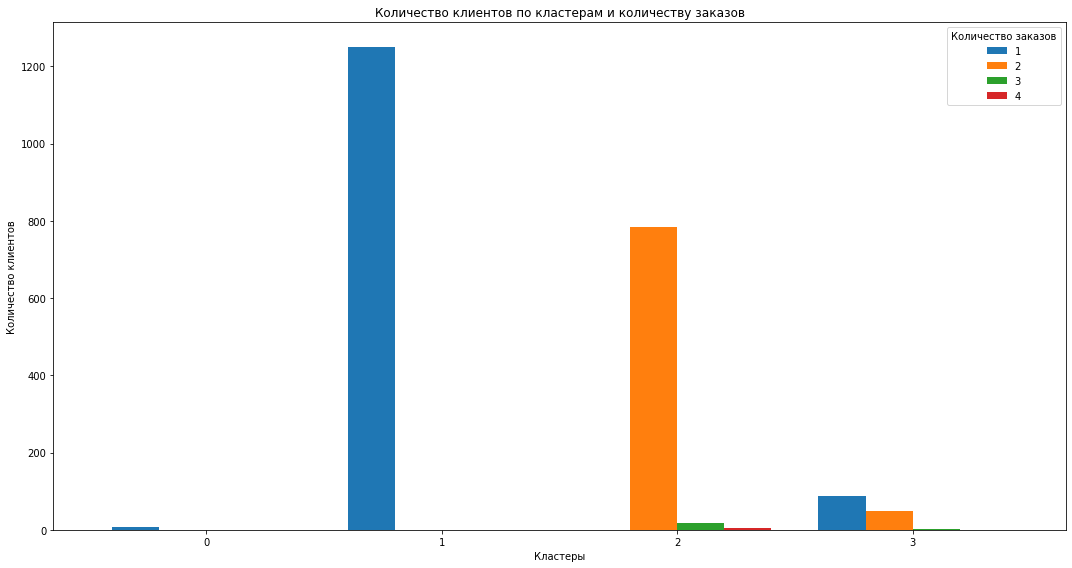

In [43]:
#группируем данные по кластерам и клиентам, считаем уникальные заказы
customer_orders = data.groupby(['cluster', 'customer_id'])['order_id'].nunique().reset_index()

#переименовываем столбец для удобства
customer_orders.columns = ['cluster', 'customer_id', 'count_orders']

#считаем количество клиентов для каждого количества заказов в каждом кластере
order_counts = customer_orders.groupby(['cluster', 'count_orders']).size().unstack(fill_value=0)

#график
order_counts.plot(kind='bar', figsize=(15, 8), width=0.8)

plt.title('Количество клиентов по кластерам и количеству заказов')
plt.xlabel('Кластеры')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0)
plt.legend(title='Количество заказов')

plt.tight_layout()
plt.show()


Видим, что кластеры отличаются между собой количеством заказов.  
0 кластер - клиенты с 1 заказом  
1 кластер - клиенты с 1 заказом  
2 кластер - клиенты с 2,3 и 4 заказами в большей степени с 2 заказами  
3 кластер - клиенты с 1,2 и 3 заказами

#### Кластеры по категориям

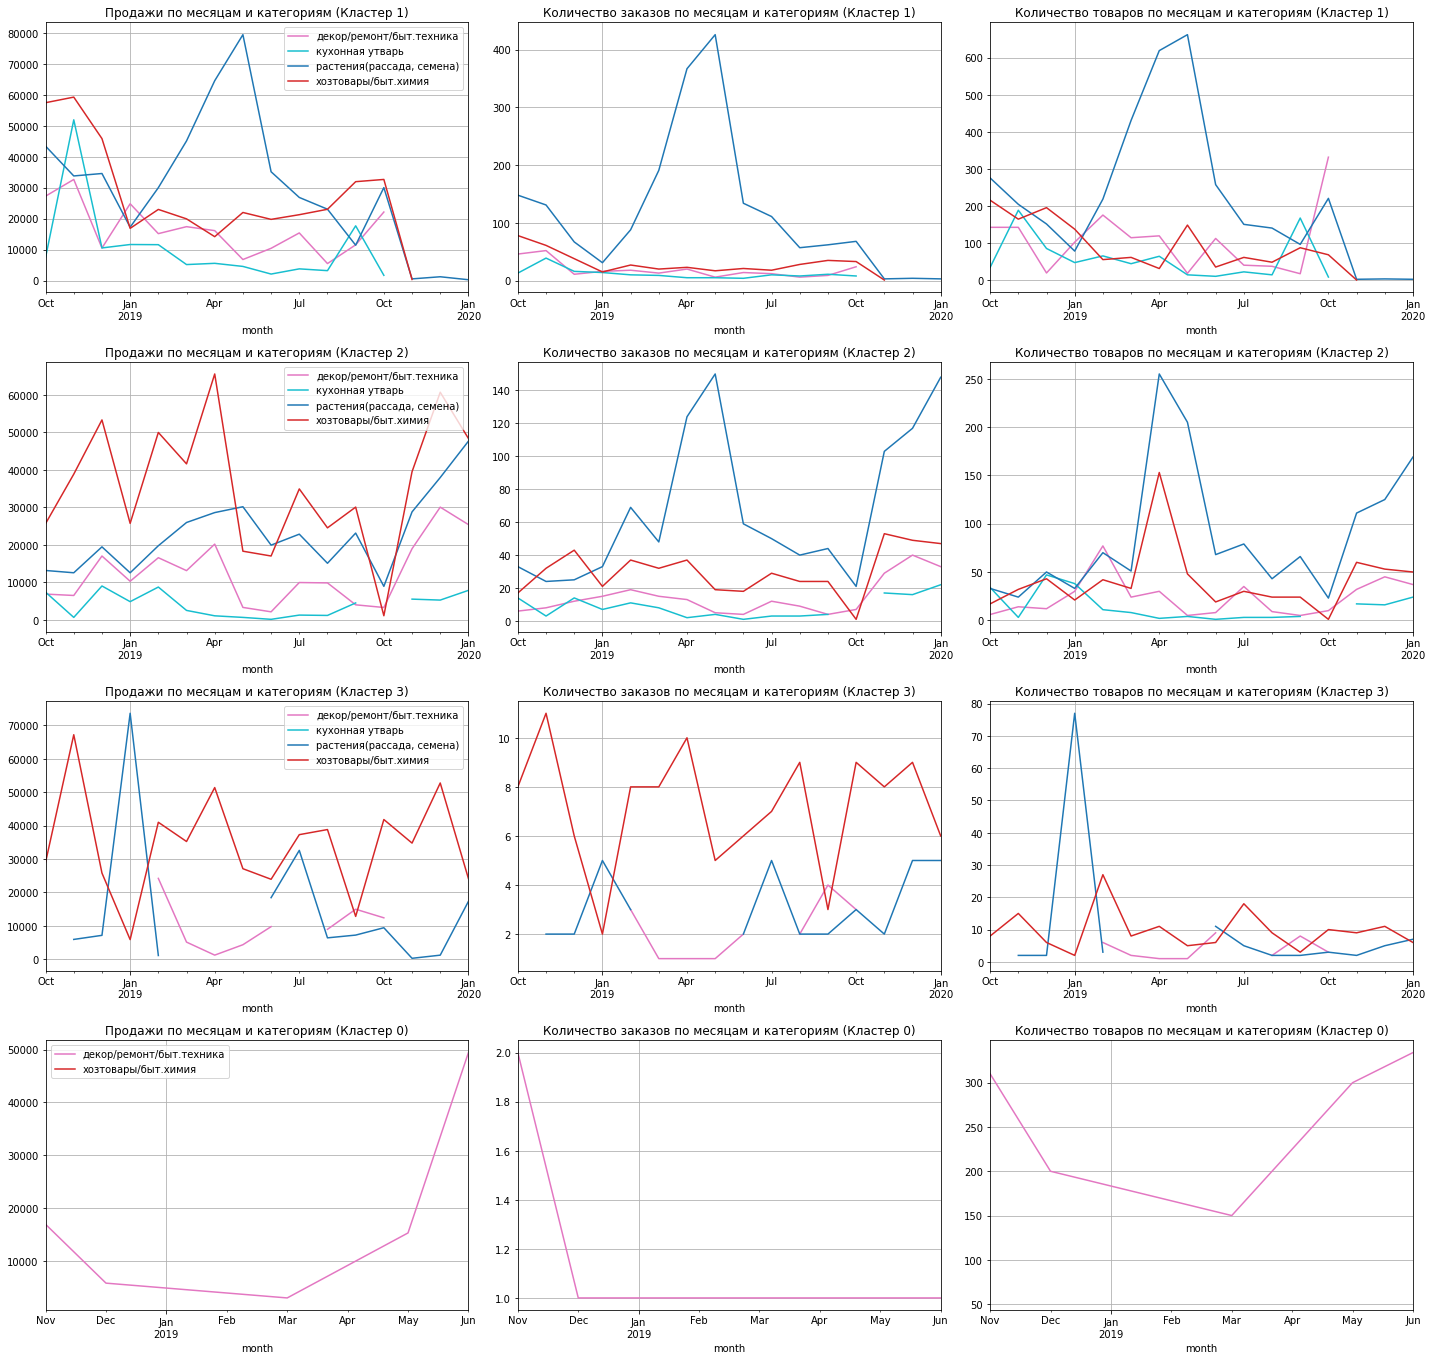

In [44]:
#получаем уникальные кластеры
clusters = data['cluster'].unique()

#определяем палитру цветов для категорий
categories = data['category'].unique()
colors = plt.cm.get_cmap('tab10', len(categories))  
category_colors = {category: colors(i) for i, category in enumerate(categories)}

#создаем фигуру для графиков
fig, axs = plt.subplots(len(clusters), 3, figsize=(20, 5 * len(clusters)))

for i, cluster in enumerate(clusters):
    #фильтруем данные по текущему кластеру
    cluster_data = data[data['cluster'] == cluster]

    #График 1: Продажи по месяцам и категориям
    pivot_sales = cluster_data.pivot_table(
        index='month',
        columns='category',
        values='cost',
        aggfunc='sum'
    )
    pivot_sales.plot(
        kind='line',
        color=[category_colors[cat] for cat in pivot_sales.columns],
        ax=axs[i, 0]
    )
    axs[i, 0].grid()
    axs[i, 0].set_title(f'Продажи по месяцам и категориям (Кластер {cluster})')
    axs[i, 0].legend(pivot_sales.columns)

    #График 2: Количество заказов по месяцам и категориям
    pivot_orders = cluster_data.pivot_table(
        index='month',
        columns='category',
        values='order_id',
        aggfunc='count'
    )
    pivot_orders.plot(
        kind='line',
        color=[category_colors[cat] for cat in pivot_orders.columns],
        ax=axs[i, 1]
    )
    axs[i, 1].grid()
    axs[i, 1].set_title(f'Количество заказов по месяцам и категориям (Кластер {cluster})')
    axs[i, 1].legend().set_visible(False)

    #График 3: Количество товаров в заказе по месяцам и категориям
    pivot_quantity = cluster_data.pivot_table(
        index='month',
        columns='category',
        values='quantity',
        aggfunc='sum'
    )
    pivot_quantity.plot(
        kind='line',
        color=[category_colors[cat] for cat in pivot_quantity.columns],
        ax=axs[i, 2]
    )
    axs[i, 2].grid()
    axs[i, 2].set_title(f'Количество товаров по месяцам и категориям (Кластер {cluster})')
    axs[i, 2].legend().set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Видим, что
- кластер 0 - это клиенты, которые заказывают по 1 заказу товары категории Декор/ремонт/быт.техника в большом количестве (по 150-350 шт в месяц).
- кластер 1 - это большая часть клиентов, которые покупают товары всех категорий, особенно товары категории Растения. Пик продаж в весенний период (март-май) делаем этот кластер. После октября-ноября 2019 заказы этого кластера резко прекратились.
- кластер 2 - это клиенты, которые также покупают товары всех категорий, особенно товары категории Растения и Хозтовары, участвовали в весеннем пике продаж Растений. 
- кластер 3 - это клиенты, которые также покупают товары всех категорий, особенно товары категории Хозтовары, в весеннем пике продаж Растений не участвовали, зато хорошо покупали их в январе

#### Средние значения

Посмотрим на какую среднюю сумму, как часто и с каким средним прайсом покупают клиенты каждого кластера

In [45]:
grouped_by_orders = data.groupby('customer_id').agg({
    'order_id': 'nunique',
    'quantity': 'sum',  
    'price': 'mean',
    'cost': 'sum',
    'cluster': 'first'  #взяли первый кластер, так как у каждого клиента один кластер
}).reset_index()

#группируем по кластерам, смотрим среднее
grouped_by_orders.groupby('cluster').mean().reset_index()

,cluster,order_id,quantity,price,cost
0,0,1.000000,193.000000,133.142857,17597.142857
1,1,1.000000,5.595524,425.143391,974.916867
2,2,2.031056,3.290683,643.420061,1489.685611
3,3,1.372263,2.386861,3767.349757,6293.368613


Видим, что:
- кластер 0:
  - 1 заказ на клиента, 
  - 193 шт товара в заказе
  - 133 руб - ср.цена товара
  - 17597 руб -ср. стоимость заказа 
- кластер 1:
  - 1 заказа на клиента, 
  - 6 шт товара в заказе
  - 425 руб - ср.цена товара
  - 975 руб -ср. стоимость заказа
- кластер 2:
  - 2 заказа на клиента, 
  - 3 шт товара в заказе
  - 643 руб - ср.цена товара
  - 1490 руб -ср. стоимость заказа  
- кластер 3:
  - 1 заказа на клиента, 
  - 2 шт товара в заказе
  - 3767 руб - ср.цена товара
  - 6293 руб -ср. стоимость заказа 

### Промежуточный вывод

Клиенты были разделены на 4 кластера:

- кластер 0 "оптовики":
  - 7 клиентов,
  - 1 заказ на клиента, 
  - 193 шт товара в заказе
  - 133 руб - ср.цена товара
  - 17597 руб -ср. стоимость заказа 
  - заказывают товары категории Декор/ремонт/быт.техника в большом количестве (по 150-350 шт в месяц)
- кластер 1 "садоводы":
  - 1251 клиент,
  - 1 заказа на клиента, 
  - 6 шт товара в заказе
  - 425 руб - ср.цена товара
  - 975 руб -ср. стоимость заказа
  - покупают товары всех категорий, особенно товары категории Растения. Пик продаж в весенний период (март-май) делаем этот кластер
  - после октября-ноября 2019 заказы резко прекратились
- кластер 2 "2 заказа":
  - 805 клиентов,
  - 2 заказа на клиента, 
  - 3 шт товара в заказе
  - 643 руб - ср.цена товара
  - 1490 руб -ср. стоимость заказа 
  - покупают товары всех категорий, особенно товары категории Растения и Хозтовары, участвовали в весеннем пике продаж Растений
- кластер 3 "хозтовары+":
  - 137 клиентов,
  - 1 заказа на клиента, 
  - 2 шт товара в заказе
  - 3767 руб - ср.цена товара
  - 6293 руб -ср. стоимость заказа 
  - покупают товары всех категорий, особенно товары категории Хозтовары, в весеннем пике продаж Растений не участвовали, зато хорошо покупали их в январе

## Гипотезы

### Кластеры отличаются по среднему чеку

Нулевая гипотеза: Нет различий между средними чеками в разных кластерах   
Альтернативная (двухсторонняя) гипотеза: Есть различия между средними чеками в разных кластерах

Проверим на нормальность распределения средних чеков, используя тест Шапиро-Уилка

In [46]:
#группируем данные по клиентам и кластерам и вычисляем средний чек
average_checks = data.groupby(['customer_id', 'cluster'])['cost'].mean().reset_index()

#проверяем нормальность распределения средних чеков
#тест Шапиро-Уилка
shapiro_test = stats.shapiro(average_checks['cost'])
print(f'Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

#результат проверки нормальности распределения
alpha = 0.05  # уровень значимости
if shapiro_test.pvalue > alpha:
    print("Распределение средних чеков нормально.")
else:
    print("Распределение средних чеков не нормально.")

Shapiro-Wilk Test: Statistic=0.3804742097854614, p-value=0.0
Распределение средних чеков не нормально.


Распределение не нормальное, для проверки гипотез используем тест Краскела-Уоллиса, которому не принциальна нормальность распределения.

In [47]:
#рассчитаем средний чек по каждому клиенту
data['avg_check'] = data.groupby('customer_id')['cost'].transform('mean')

#разделим данные по кластерам
clusters = data['cluster'].unique()

#создадим список для хранения данных по каждому кластеру
cluster_data = [data[data['cluster'] == cluster]['avg_check'].values for cluster in clusters]

#тест Краскала-Уоллиса
stat, p_value = kruskal(*cluster_data)

#результаты
print(f"Статистика теста: {stat}")
print(f"P-значение: {p_value}")

#интерпретация результатов
alpha = 0.01 #скорректирован уровень стат.значимости методом Бонферрони 
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Средние чеки в разных кластерах различаются.")
else:
    print("Не отвергаем нулевую гипотезу. Средние чеки в разных кластерах не различаются.")


Статистика теста: 818.5931895255821
P-значение: 4.015606297416468e-177
Отвергаем нулевую гипотезу. Средние чеки в разных кластерах различаются.


На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) есть основания отвергнуть
нулевую гипотезу в пользу двухсторонней альтернативной гипотезы.   
Средние чеки в разных кластерах имеют стат.значимую разницу.

### Кластеры отличаются по частоте покупок

Нулевая гипотеза: нет различий между частотой покупок в разных кластерах  
Альтернативная (двухсторонняя) гипотеза: есть различия между частотой покупок в разных кластерах

In [48]:
#данные по клиентам и считаем количество заказов для каждого
order_counts = data.groupby('customer_id')['order_id'].count().reset_index()
order_counts.rename(columns={'order_id': 'order_count'}, inplace=True)

df_with_orders = pd.merge(data, order_counts, on='customer_id', how='left')

#разбиваем по кластерам
clusters = df_with_orders.groupby('cluster')['order_count'].apply(list)

#тест Краскала-Уоллиса
stat, p_value = kruskal(*clusters)

#результат
alpha = 0.01   #скорректирован уровень стат.значимости методом Бонферрони 
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: частота заказов по клиентам в разных кластерах имеет различия.")
else:
    print("Не отвергаем нулевую гипотезу: частота заказов по клиентам в разных кластерах не имеет различия.")


Отвергаем нулевую гипотезу: частота заказов по клиентам в разных кластерах имеет различия.


На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) есть основания отвергнуть
нулевую гипотезу в пользу двухсторонней альтернативной гипотезы.   
Частота заказов клиентов в разных кластерах имеют стат. значимую разницу.

### Промежуточный вывод

На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) есть основания отвергнуть
нулевую гипотезу в пользу двухсторонней альтернативной гипотезы:   
- Средние чеки в разных кластерах имеют стат. значимую разницу.
- Частота заказов клиентов в разных кластерах  имеют стат. значимую разницу.

## ОБЩИЙ ВЫВОД

**Краткий обзор проведённой работы:**

В нашем распоряжении 7474 строк данных.
Этих данных достаточно для анализа.
Видим что имеются некорректные типы данных и выбросы. Пропуски и явные дубликаты отсутствуют.

Проведена предобработка:
1. обработаны выбросы и дубли
2. изменены типы данных:
 - date - дата
3. созданы новые столбцы
 - month - с месяцем заказа month
 - category - категории товаров 
 - cost - стоимость заказа
 
 
Проверены такие гипотезы как:
 - Средние чеки в разных кластерах не имеют различий?
 - Частота заказов клиентов в разных кластерах не имеют различий? 
 
    
**Главные выводы** 

Каждый месяц (кроме января 2019) имеем более 190 заказов, в апреле-мае 2019 был пик количества заказов - более 600. В 4 квартале 2018 года было больше заказов (290-430 заказов), чем в остальных месяцах 2019 (кроме апреля-мая). В январе существенно меньше заказов, чем в остальные месяцы. 

Выручка составляет от 130 тыс до 310 тыс в месяц. Самыми удачными месяцами в плане выручки являются 4 квартал 2018 года, февраль и апрель 2019 г. Месяцами с наименьшей выручкой являются январь, июнь и ноябрь 2019 года. 

В основном продажи и по сумме, и по количеству заказов относятся к двум категориям: растения(рассада, семена) и хозтовары. Более 60% заказов занимает категория растения, но при этом приносит только 30% всей выручки. Больше всего выручки 47% приносит категория хозтовары.

Растения чаще заказывают, особенно заметен пик заказов весной, время посадок (апрель-май). Выручка в мае-июне по категории растения даже выше выручки категории за хозтовары. В январе продажи сильно проваливаются (и по количеству заказов, и по выручке), что можно объяснить новогодними выходными.

Каждый месяц более 140 уникальных клиентов. Более 200 новых клиентов появилось в декабре 2018, феврале, марте, апреле, ноябре, декабре 2019 и январе 2020.Самое маленькое количество новых клиентов было в январе и июне 2019 года.

Клиенты чаще всего не делают больше 2 заказов. Единицы заказывают более 4 заказов.

На протяжении всего периода до октября 2019 преобладали покупатели с 1 заказом. Клиенты свои 3 и 4 заказа набирали также в течение  всего периода до октября 2019.

В октябре 2019 произошло несколько изменений: 
 - увеличилось количество вторых заказов
 - клиенты, заказывающие более 2 заказов, отсутствуют
 
 
Клиенты были разделены на 4 кластера:

- кластер 0 "оптовики":
  - 7 клиентов,
  - 1 заказ на клиента, 
  - 193 шт товара в заказе
  - 133 руб - ср.цена товара
  - 17597 руб -ср. стоимость заказа 
  - заказывают товары категории Декор/ремонт/быт.техника в большом количестве (по 150-350 шт в месяц)
- кластер 1 "садоводы":
  - 1251 клиент,
  - 1 заказа на клиента, 
  - 6 шт товара в заказе
  - 425 руб - ср.цена товара
  - 975 руб -ср. стоимость заказа
  - покупают товары всех категорий, особенно товары категории Растения. Пик продаж в весенний период (март-май) делаем этот кластер
  - после октября-ноября 2019 заказы резко прекратились
- кластер 2 "2 заказа":
  - 805 клиентов,
  - 2 заказа на клиента, 
  - 3 шт товара в заказе
  - 643 руб - ср.цена товара
  - 1490 руб -ср. стоимость заказа 
  - покупают товары всех категорий, особенно товары категории Растения и Хозтовары, участвовали в весеннем пике продаж Растений
- кластер 3 "хозтовары+":
  - 137 клиентов,
  - 1 заказа на клиента, 
  - 2 шт товара в заказе
  - 3767 руб - ср.цена товара
  - 6293 руб -ср. стоимость заказа 
  - покупают товары всех категорий, особенно товары категории Хозтовары, в весеннем пике продаж Растений не участвовали, зато хорошо покупали их в январе

**Гипотезы**

На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) есть основания отвергнуть
нулевую гипотезу в пользу двухсторонней альтернативной гипотезы:   
- Средние чеки в разных кластерах имеют стат. значимую разницу.
- Частота заказов клиентов в разных кластерах  имеют стат. значимую разницу.

**Рекомендации** 

Рассылки по кластерам:

Кластер 0 "оптовики":  
        1.специальные оптовые скидки и акции для увеличения объема закупок.  
        2.специальные предложения для товаров категории Декор/ремонт/быт.техника, которые пользуются большим спросом.  
        3.разработать программу лояльности для постоянных оптовых клиентов.  
        4.упрощенный способ получения документов для бухг и налогового учета.  

Кластер 1 "садоводы":  
        1.весенняя рекламная кампания, с акцентом на товары категории Растения.  
        2.рассылка новинок из категории Растения и сопутствующих товаров (грунт, удобрения, садовые инструменты и т.д)  
        3.информационные материалы о садоводстве и уходе за растениями для привлечения новых клиентов.  

Кластер 2 "2 заказа":  
        1. персонализированные скидки и бонусы для клиентов, совершивших повторные заказы.  
        2. акционные товары категории Растения и Хозтовары.  

Кластер 3 "хозтовары+":  
        1. специальные предложения и акции на товары категории Хозтовары.  
        2. каталог товаров с подробным описанием и рекомендациями.  